# Load libraries

In [1]:
import os
import glob
import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib import pyplot
from sklearn import metrics

# Load and Combine Datasets

In [2]:
# Make a list of all the decade dataset file names.
all_file_names = [i for i in glob.glob('./Spotify/*.csv')]

# Sort the list so decades appear in chronological order.
all_file_names = sorted(all_file_names, key=lambda decade: int(decade[-9:-5]))

all_decades = []
for file_name in all_file_names:
    # Create the dataframe.
    decade = pd.DataFrame(pd.read_csv(file_name))
    # Name the dataframe by the decade.
    decade.name = file_name[-9:-5]
    all_decades.append(decade)

# Add a decade column to each decade dataframe.
for decade in all_decades:
    decade['decade'] = int(decade.name)

# Combine all decades into one dataframe.
df = pd.concat([f for f in all_decades ], ignore_index = True)

# Dataset Information

In [3]:
# Total number, hits and flops.
print("Total")
print(str(len(df.index)) + ' total tracks')
print(str(df['target'].value_counts()[1]) + ' hits')
print(str(df['target'].value_counts()[0]) + ' flops')
print("")

# Number, hits and flops for each decade.
for decade in all_decades:
    print(decade.name)
    print(str(len(decade.index)) + ' total tracks')
    print(str(decade['target'].value_counts()[1]) + ' hits')
    print(str(decade['target'].value_counts()[0]) + ' flops')
    print("")

# Head of data set.
print(df.head())

Total
41106 total tracks
20553 hits
20553 flops

1960
8642 total tracks
4321 hits
4321 flops

1970
7766 total tracks
3883 hits
3883 flops

1980
6908 total tracks
3454 hits
3454 flops

1990
5520 total tracks
2760 hits
2760 flops

2000
5872 total tracks
2936 hits
2936 flops

2010
6398 total tracks
3199 hits
3199 flops

                   track            artist  \
0  Jealous Kind Of Fella     Garland Green   
1          Initials B.B.  Serge Gainsbourg   
2           Melody Twist       Lord Melody   
3          Mi Bomba Sonó        Celia Cruz   
4            Uravu Solla       P. Susheela   

                                    uri  danceability  energy  key  loudness  \
0  spotify:track:1dtKN6wwlolkM8XZy2y9C1         0.417   0.620    3    -7.727   
1  spotify:track:5hjsmSnUefdUqzsDogisiX         0.498   0.505    3   -12.475   
2  spotify:track:6uk8tI6pwxxdVTNlNOJeJh         0.657   0.649    5   -13.392   
3  spotify:track:7aNjMJ05FvUXACPWZ7yJmv         0.590   0.545    7   -12.058   
4  s

# Data Analysis
My runtime: 26 seconds

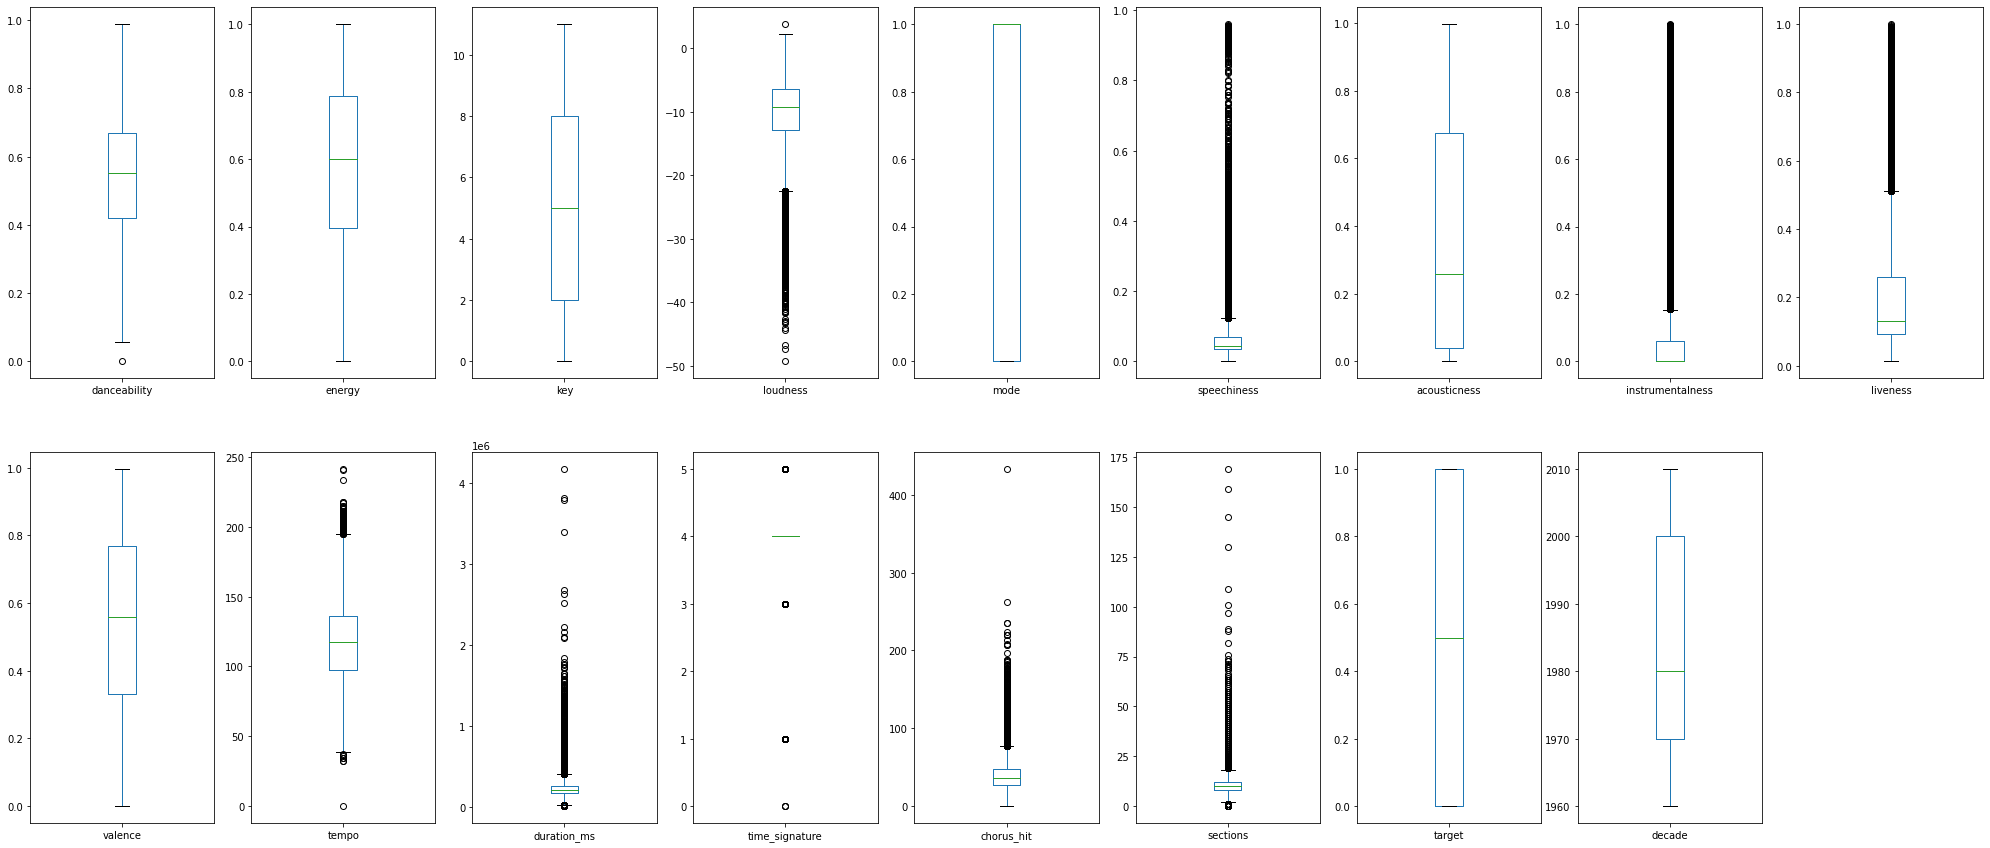

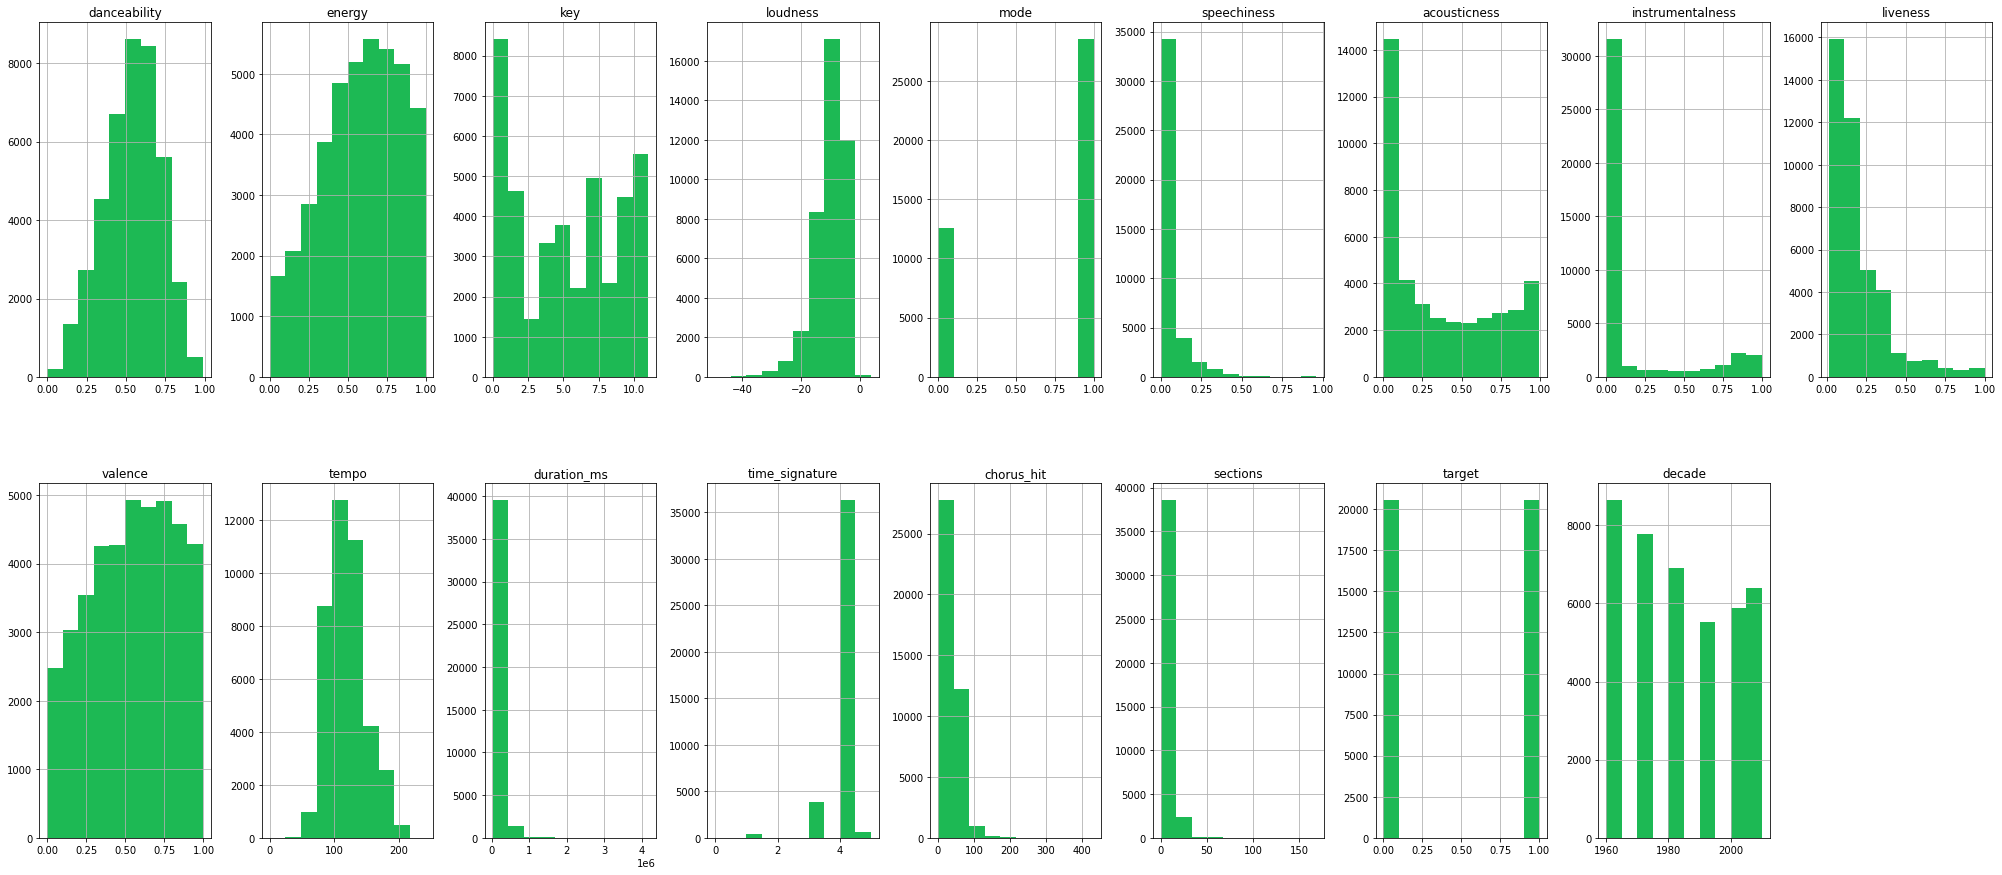

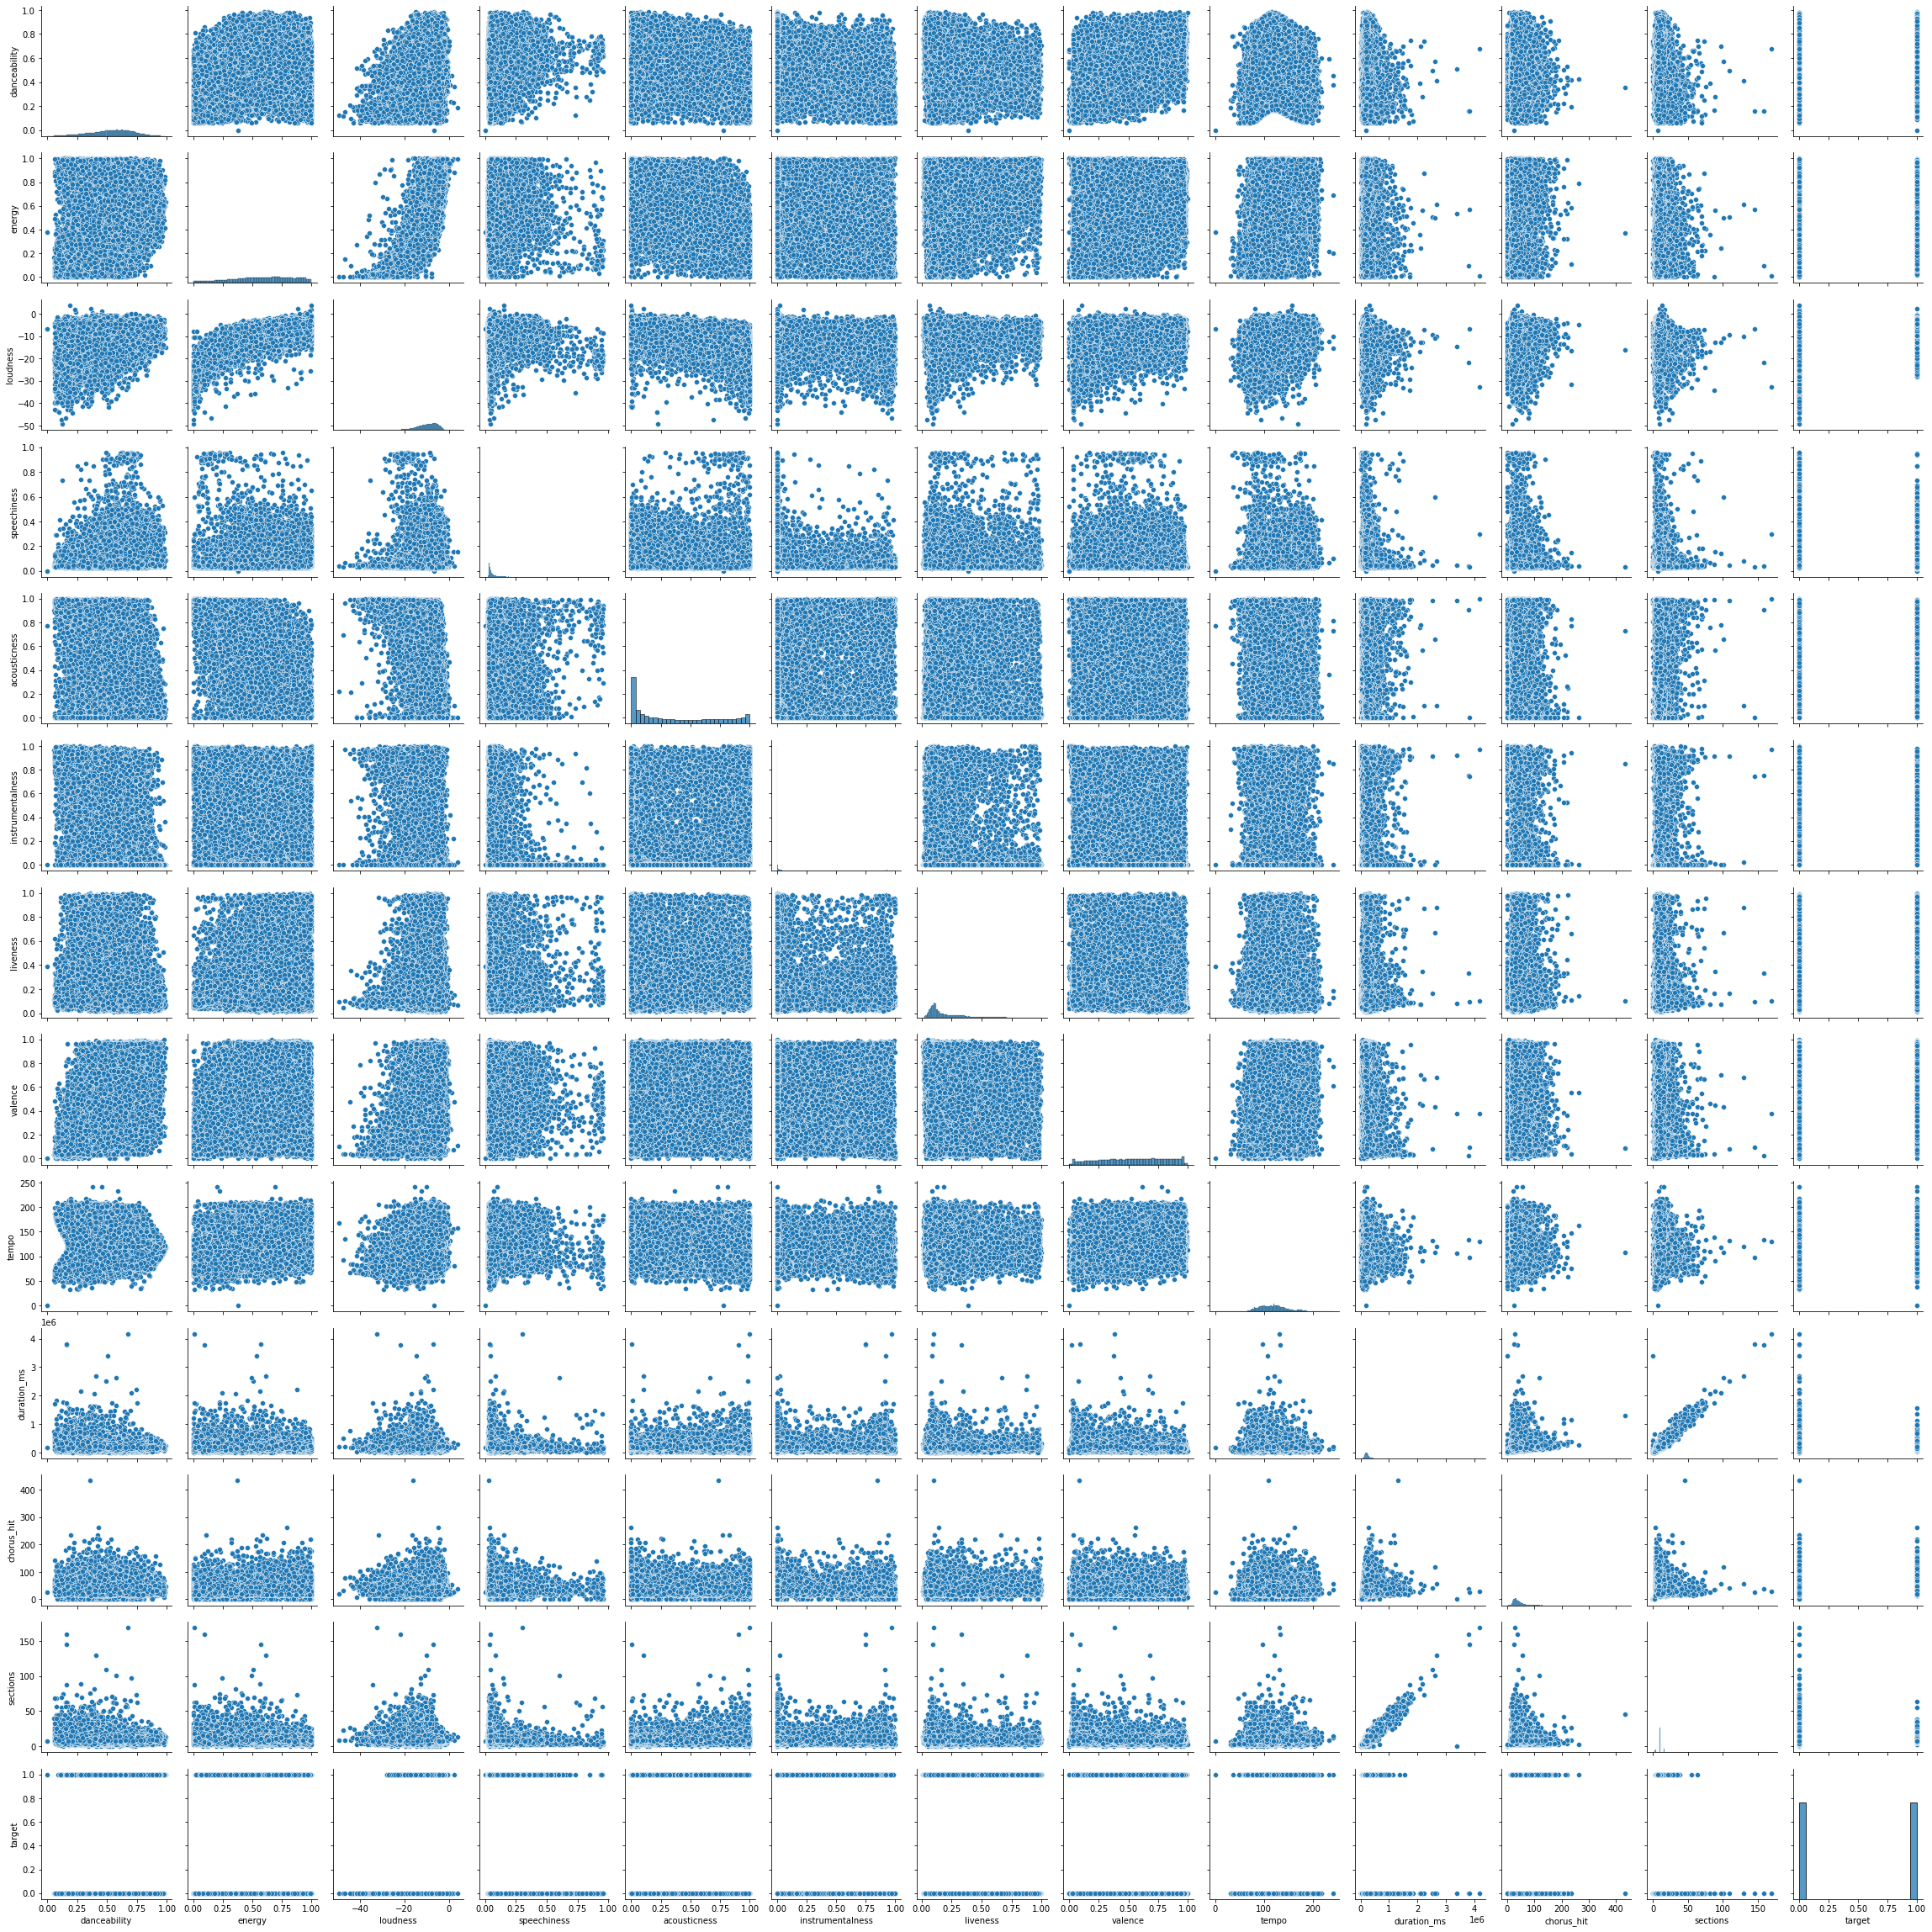

In [4]:
# Box and whisker plots for each feature.
df.plot(kind='box', subplots=True, layout=(2,9), figsize=(35,15))

# Histograms for each feature.
df.hist(layout=(2,9), color = '#1DB954', figsize=(35,15))

# Scatter plots against all features included in the list below.
sns.pairplot(df, vars=['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
                       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
                       'chorus_hit', 'sections', 'target'])

# Used to plot single scatter plots that be shown in the report.
#sns.relplot(x='loudness', y='energy', data=df)

pyplot.show()

# Data Cleaning and Feature Engineering

No null values
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
chorus_hit          0
sections            0
target              0
decade              0
dtype: int64


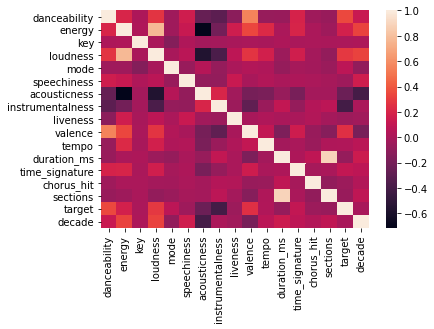

In [5]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

# Removes categorical features.
df = df.drop(labels=['track', 'artist', 'uri'], axis=1)

# Check for null values in the dataframe.
print('Dataset contains null values' if df.isnull().values.any() else 'No null values')
print(df.isnull().sum())

# Displays a heatmap of the correlation strength between features.
sns.heatmap(df.corr())

# Removes features with a high correlation with the target feature.
# In this case no features were removed.
corr = df.corr()
corr_columns = []
for i in range(len(corr.columns)):
    if (corr.iloc[i, -2] >= 0.6) and corr.columns[i] != 'target':
        # Add feature to list of features to delete.
        corr_columns.append(corr.columns[i])
df = df.drop(labels=corr_columns, axis=1)

# Scale features to be used for prediction.
X = sc.fit_transform(df.values[:,0:15])

# Target feature 'hit' (1) or 'flop' (0) column to predict.
Y = df.values[:,15]

# Data Splitting

In [6]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

# Split data between training and testing in a 4:1 ratio respectively.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

# Collect the split data into a dictionary.
total_data = {
    'X_train': X_train.tolist(),
    'X_test': X_test.tolist(),
    'Y_train': Y_train.tolist(),
    'Y_test': Y_test.tolist()
}

decade_data = {}

# Iterate through each decade.
for decade, tracks in df.groupby('decade'):

    # Features to be used for prediction.
    X_decade = sc.fit_transform(tracks.values[:,0:15])

    # 'hit' (1) or 'flop' (0) column to predict.
    Y_decade = tracks.values[:,15]

    # Split data between training and testing in a 4:1 ratio respectively.
    X_train, X_test, Y_train, Y_test = train_test_split(X_decade, Y_decade, test_size=0.20, random_state=1)

    # Collect the split data into a dictionary.
    decade_data[decade] = {
        'X_train': X_train.tolist(),
        'X_test': X_test.tolist(),
        'Y_train': Y_train.tolist(),
        'Y_test': Y_test.tolist()
    }


# Model 1 - Multilayer Perceptron Classification

## Parameter Selection
Best parameters were the default parameters. Commented out as it takes a while to run.

In [7]:
"""
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Defines the parameters to use.
parameter_space = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'max_iter': [200, 300, 500, 1000],
    'learning_rate': ['constant','adaptive'],
}

mlp = MLPClassifier()
# Run the model using combinations of parameters set.
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(total_data['X_train'], total_data['Y_train'])
print('Best parameters found:\n', clf.best_params_)

print('Results on the test set:')
print(classification_report(total_data['Y_test'], clf.predict(total_data['X_test'])))
"""

"\nfrom sklearn.neural_network import MLPClassifier\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import classification_report\n\n# Defines the parameters to use.\nparameter_space = {\n    'activation': ['identity', 'logistic', 'tanh', 'relu'],\n    'solver': ['sgd', 'adam'],\n    'max_iter': [200, 300, 500, 1000],\n    'learning_rate': ['constant','adaptive'],\n}\n\nmlp = MLPClassifier()\n# Run the model using combinations of parameters set.\nclf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)\nclf.fit(total_data['X_train'], total_data['Y_train'])\nprint('Best parameters found:\n', clf.best_params_)\n\nprint('Results on the test set:')\nprint(classification_report(total_data['Y_test'], clf.predict(total_data['X_test'])))\n"

## Training and Predictions
My runtime: 1 minute, 53 seconds

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

predictions_MLP = []
avg_accuracy = 0

clf_MLP = MLPClassifier(random_state=1)

# Iterate through each decade
for decade in range(1960, 2020, 10):

    print(str(decade))

    # Train the classifier for tracks in that decade only.
    clf_MLP.fit(decade_data[decade]['X_train'], decade_data[decade]['Y_train'])

    # Cross validation scores
    CV_scores = cross_val_score(clf_MLP, decade_data[decade]['X_train'], decade_data[decade]['Y_train'], cv=5)
    print("%0.2f%% accuracy with a standard deviation of %0.2f%% using 5-fold cross-validation." % (CV_scores.mean()*100, CV_scores.std()*100))

    # Make predictions using the test data.
    prediction = clf_MLP.predict(decade_data[decade]['X_test'])
    predictions_MLP.append(prediction)


    print(metrics.classification_report(decade_data[decade]['Y_test'], prediction))

    avg_accuracy += CV_scores.mean()

    print('-------------------------------------------------------')


print('Total average accuracy: ' + str(round(avg_accuracy/6, 3)*100) + '%')


1960


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

76.58% accuracy with a standard deviation of 0.90%
              precision    recall  f1-score   support

         0.0       0.82      0.70      0.76       880
         1.0       0.73      0.84      0.78       849

    accuracy                           0.77      1729
   macro avg       0.78      0.77      0.77      1729
weighted avg       0.78      0.77      0.77      1729

-------------------------------------------------------
1970


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

76.08% accuracy with a standard deviation of 0.70%
              precision    recall  f1-score   support

         0.0       0.78      0.70      0.73       771
         1.0       0.73      0.80      0.76       783

    accuracy                           0.75      1554
   macro avg       0.75      0.75      0.75      1554
weighted avg       0.75      0.75      0.75      1554

-------------------------------------------------------
1980


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

79.73% accuracy with a standard deviation of 0.61%
              precision    recall  f1-score   support

         0.0       0.81      0.74      0.78       670
         1.0       0.77      0.84      0.81       712

    accuracy                           0.79      1382
   macro avg       0.79      0.79      0.79      1382
weighted avg       0.79      0.79      0.79      1382

-------------------------------------------------------
1990


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

84.22% accuracy with a standard deviation of 1.15%
              precision    recall  f1-score   support

         0.0       0.90      0.80      0.85       571
         1.0       0.81      0.90      0.85       533

    accuracy                           0.85      1104
   macro avg       0.85      0.85      0.85      1104
weighted avg       0.85      0.85      0.85      1104

-------------------------------------------------------
2000


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

85.01% accuracy with a standard deviation of 0.88%
              precision    recall  f1-score   support

         0.0       0.88      0.80      0.84       590
         1.0       0.82      0.89      0.85       585

    accuracy                           0.85      1175
   macro avg       0.85      0.85      0.84      1175
weighted avg       0.85      0.85      0.84      1175

-------------------------------------------------------
2010


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

82.86% accuracy with a standard deviation of 0.82%
              precision    recall  f1-score   support

         0.0       0.84      0.77      0.80       633
         1.0       0.79      0.85      0.82       647

    accuracy                           0.81      1280
   macro avg       0.81      0.81      0.81      1280
weighted avg       0.81      0.81      0.81      1280

-------------------------------------------------------
Total average accuracy: 80.7%


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Confusion Matrices

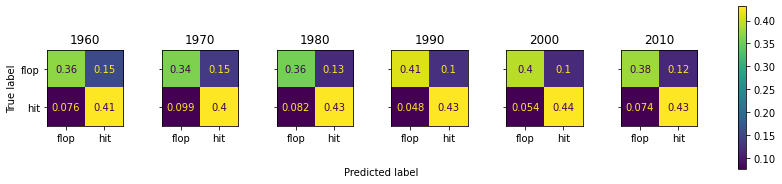

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

decade = 1960
f, axes = pyplot.subplots(1, 6, figsize=(15, 3), sharey='row')

# Iterate through each decade's predictions.
for i, prediction in enumerate(predictions_MLP):

    # Calculate confusion matrix.
    cm = confusion_matrix(decade_data[decade]['Y_test'], prediction, normalize='all')

    # Displays all matrices in a row.
    disp = ConfusionMatrixDisplay(cm, display_labels=['flop', 'hit'])
    disp.plot(ax=axes[i])
    disp.ax_.set_title(decade)
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

    decade += 10

f.text(0.4, 0.1, 'Predicted label', ha='left')
f.colorbar(disp.im_, ax=axes)

pyplot.show()

# Model 2 -  Logistic Regression

## Training and Predictions

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

predictions_LR = []
feature_importance = []
avg_accuracy = 0

clf_LR = LogisticRegression(random_state=1)

# Iterate through each decade
for decade in range(1960, 2020, 10):

    print(str(decade))

    # Train the classifier for tracks in that decade only.
    clf_LR.fit(decade_data[decade]['X_train'], decade_data[decade]['Y_train'])

    # Save the feature importance for each decade.
    feature_importance.append(clf_LR.coef_[0])

    # Cross validation scores.
    scores = cross_val_score(clf_LR, decade_data[decade]['X_train'], decade_data[decade]['Y_train'], cv=5)
    print("%0.2f%% accuracy with a standard deviation of %0.2f%% using 5-fold cross-validation." % (scores.mean()*100, scores.std()*100))

    # Make predictions using the test data.
    prediction = clf_LR.predict(decade_data[decade]['X_test'])
    predictions_LR.append(prediction)

    print(metrics.classification_report(decade_data[decade]['Y_test'], prediction))

    avg_accuracy += metrics.accuracy_score(decade_data[decade]['Y_test'], prediction)

    print('-------------------------------------------------------')

print('Total average accuracy: ' + str(round(avg_accuracy/6, 3)*100) + '%')


1960
72.37% accuracy with a standard deviation of 1.30%
              precision    recall  f1-score   support

         0.0       0.74      0.67      0.70       880
         1.0       0.69      0.76      0.72       849

    accuracy                           0.71      1729
   macro avg       0.71      0.71      0.71      1729
weighted avg       0.72      0.71      0.71      1729

-------------------------------------------------------
1970
71.51% accuracy with a standard deviation of 0.90%
              precision    recall  f1-score   support

         0.0       0.73      0.66      0.69       771
         1.0       0.69      0.76      0.73       783

    accuracy                           0.71      1554
   macro avg       0.71      0.71      0.71      1554
weighted avg       0.71      0.71      0.71      1554

-------------------------------------------------------
1980
77.22% accuracy with a standard deviation of 0.77%
              precision    recall  f1-score   support

         0.

## Confusion Matrices

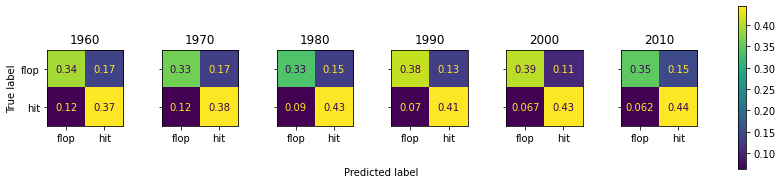

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

decade = 1960
f, axes = pyplot.subplots(1, 6, figsize=(15, 3), sharey='row')

# Iterate through each decade's predictions.
for i, prediction in enumerate(predictions_LR):

    # Calculate confusion matrix.
    cm = confusion_matrix(decade_data[decade]['Y_test'], prediction, normalize='all')

    # Displays all matrices in a row.
    disp = ConfusionMatrixDisplay(cm, display_labels=['flop', 'hit'])
    disp.plot(ax=axes[i])
    disp.ax_.set_title(decade)
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

    decade += 10

f.text(0.4, 0.1, 'Predicted label', ha='left')
f.colorbar(disp.im_, ax=axes)

pyplot.show()

# All Time Predictor
Using the entire dataset for predictions regardless of decade.

## Training and Predictions
My runtime: 20 seconds

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

predictions_MLP_total = []

clf_LR_total = LogisticRegression(random_state=1)

# Train the classifier for tracks in that decade only.
clf_LR_total.fit(total_data['X_train'], total_data['Y_train'])

# Make predictions using the test data.
prediction = clf_LR_total.predict(total_data['X_test'])
predictions_MLP_total.append(prediction)

# Show prediction results.
print(metrics.classification_report(total_data['Y_test'], prediction))

# Cross-validation results.
CV_scores = cross_val_score(clf_LR_total, total_data['X_train'], total_data['Y_train'], cv=5)
print("%0.2f%% accuracy with a standard deviation of %0.2f%% using 5-fold cross-validation." % (CV_scores.mean()*100, CV_scores.std()*100))


              precision    recall  f1-score   support

         0.0       0.78      0.64      0.70      4119
         1.0       0.69      0.82      0.75      4103

    accuracy                           0.73      8222
   macro avg       0.74      0.73      0.73      8222
weighted avg       0.74      0.73      0.73      8222

72.77% accuracy with a standard deviation of 0.41%


## Confusion Matrix

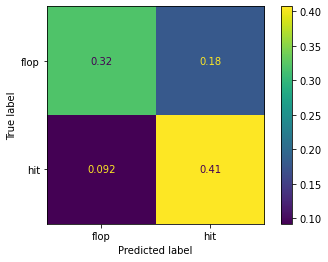

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate confusion matrix.
cm = confusion_matrix(total_data['Y_test'], prediction, normalize='all')

# Plot the matrix
ConfusionMatrixDisplay(cm, display_labels=['flop', 'hit']).plot()

pyplot.show()

# Final Analysis

## ROC Curves

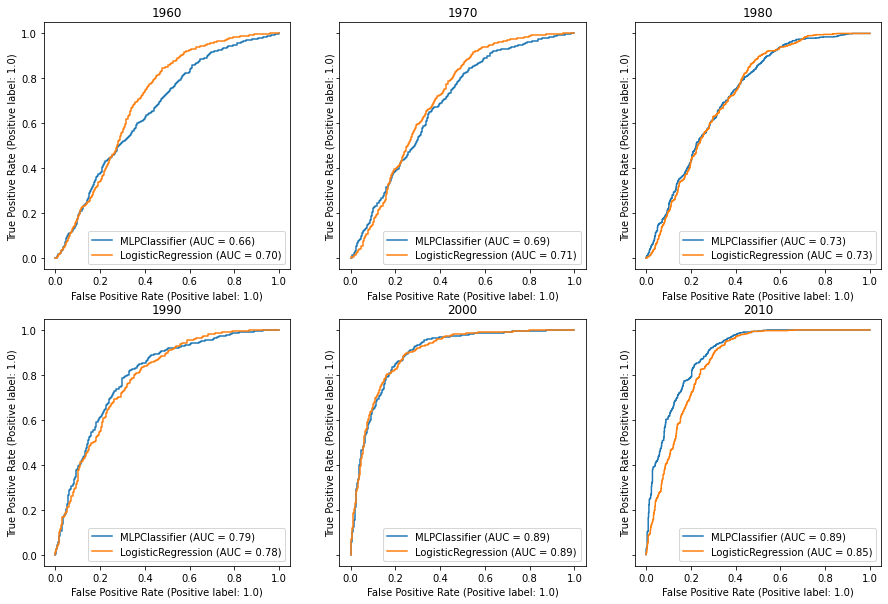

In [ ]:
from sklearn.metrics import RocCurveDisplay

decade = 1960
f, axes = pyplot.subplots(2, 3, figsize=(15, 10), sharey='row')

# Iterate through each decade's predictions.
for i in range(0, 6):

    # Draw both ROC curves onto a single graph.
    disp = RocCurveDisplay.from_estimator(clf_MLP, decade_data[decade]['X_test'], decade_data[decade]['Y_test'], ax=axes[0 if i < 3 else 1][i if i < 3 else i-3])
    disp = RocCurveDisplay.from_estimator(clf_LR, decade_data[decade]['X_test'], decade_data[decade]['Y_test'], ax=axes[0 if i < 3 else 1][i if i < 3 else i-3])
    disp.ax_.set_title(decade)

    decade += 10

pyplot.show()

## Feature Importance in Logistic Regression

Top 10 features for hits and flops displayed in a bar chart over the decades:<br>
https://public.flourish.studio/visualisation/7582843/<br>
https://public.flourish.studio/visualisation/7508200/

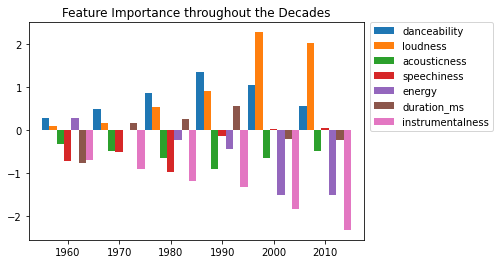

In [ ]:
# Convert the 2D array to a pandas dataframe.
feature_importance_df = pd.DataFrame(feature_importance,
                                     columns=list(df.columns[0:15]),
                                     index=[1960, 1970, 1980, 1990, 2000, 2010])

# Display the top 7 most influential features over each decade.
# Positive value influence hits the most, negative values influence flops the most.
disp = feature_importance_df.plot.bar(y=['danceability',
                                         'loudness',
                                         'acousticness',
                                         'speechiness',
                                         'energy',
                                         'duration_ms',
                                         'instrumentalness'],
                                      rot=0, width=1)

disp.set_title('Feature Importance throughout the Decades')

pyplot.legend(loc=(1.02, 0.5))
pyplot.show()